<a href="https://colab.research.google.com/github/agaldran/uqinmia-miccai-2023/blob/main/calibration_tutorial_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Table of Contents
1. [Introduction](#intro)
    1. [Data](#data)
    2. [Model Training](#training)
2. [Measuring Model Calibration](#measuring)
    1. [Expected Calibration Error](#ece)
    2. [Visualization - Reliability Plots](#plots)
3. [Improving Model Calibration](#improving)
    1. [Post-Training Calibration - Temperature Scaling](#temp)
    2. [Training Time Calibration Calibration- Label Smoothing ](#ls)

# 1. Introduction <a class="anchor" id="intro"></a>

In [ ]:
!pip install medmnist

In [ ]:
from google.colab import drive

# Mount the files of the drive
drive.mount('/content/drive/', force_remount=True)

import gdown
url = "https://drive.google.com/file/d/1c8fOm5Uk2I2ttbJ-dfEgKSfhgMI5_HCL/view?usp=drive_link"
gdown.download(url=url, output='folder.zip', quiet=False, fuzzy=True)

Mounted at /content/drive/


Downloading...
From: https://drive.google.com/uc?id=1c8fOm5Uk2I2ttbJ-dfEgKSfhgMI5_HCL
To: /content/folder.zip
100%|██████████| 250M/250M [00:03<00:00, 70.1MB/s]


'folder.zip'

In [ ]:
import zipfile
path_zip = '/content/folder.zip'
path_dst = '/content'
with zipfile.ZipFile(path_zip, 'r') as zip_file:
    # Extract all the files of the zip in the destiny path
    zip_file.extractall(path_dst)

In [ ]:
import os
# Set the path in which this notebook is save as the standard path
os.chdir(os.path.abspath('/content/MICCAI23workshop'))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [ ]:
import torch
import torchvision.transforms as tr
from torchvision.models import resnet18
from torch.utils.data import DataLoader

In [ ]:
if torch.cuda.is_available():
    print('using the GPU')
    device = 'cuda'
else:
    print('using the CPU')
    device='cpu'

using the CPU


## 1.A Data  <a class="anchor" id="data"></a>

In this hands-on session we will be playing with `medMNIST`, a collection of datasets similar to MNIST but with medical images. For the sake of quick training, we will be using skin and retinal images, as `RetinaMNIST` and `DermaMNIST` are the smallest datasets in `medMNIST`. The `dataset` variable next allows you to pick one of these.

In [ ]:
from medmnist import DermaMNIST, RetinaMNIST

dataset = 'DERMA'

Let us prepare dataloaders:

In [ ]:
# preprocessing - to-tensor and normalize using imagenet stats
transforms = tr.Compose([tr.ToTensor(), tr.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# datasets
if dataset == 'DERMA':
    train_dataset = DermaMNIST(split='train', transform=transforms, download=True)
    val_dataset   = DermaMNIST(split='val', transform=transforms, download=True)
    test_dataset  = DermaMNIST(split='test', transform=transforms, download=True)
elif dataset == 'RETINA':
    train_dataset = RetinaMNIST(split='train', transform=transforms, download=True)
    val_dataset   = RetinaMNIST(split='val', transform=transforms, download=True)
    test_dataset  = RetinaMNIST(split='test', transform=transforms, download=True)
else:
    print('please choose between dataset=\'DERMA\' or dataset=\'RETINA\'')

# dataloaders
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
val_loader   = DataLoader(dataset=val_dataset,   batch_size=256, shuffle=False)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=256, shuffle=False)

Using downloaded and verified file: /root/.medmnist/dermamnist.npz
Using downloaded and verified file: /root/.medmnist/dermamnist.npz
Using downloaded and verified file: /root/.medmnist/dermamnist.npz


### How many train/val/test examples? Class distribution?

In [ ]:
len(train_dataset), len(val_dataset), len(test_dataset)

(7007, 1003, 2005)

In [ ]:
np.unique(train_dataset.labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6], dtype=uint8),
 array([ 228,  359,  769,   80,  779, 4693,   99]))

A bit of visual inspection:

/usr/local/lib/python3.10/dist-packages/medmnist/utils.py:31: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


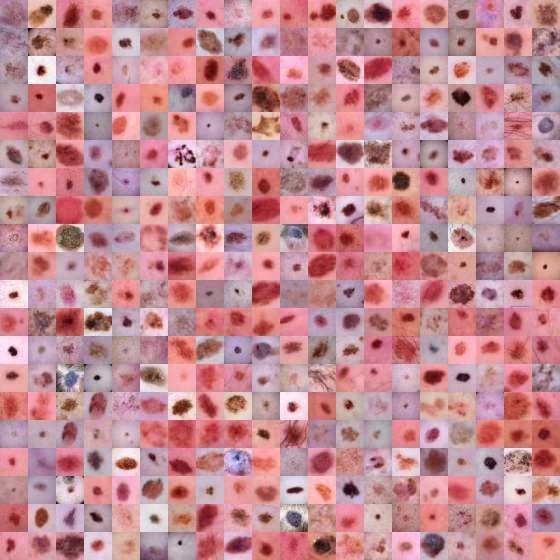

In [ ]:
train_dataset.montage(length=20)

Some hyperparameters are fixed here, depending on the dataset choice

In [ ]:
N_CLASSES = len(np.unique(train_dataset.labels))

ylim = 600 if dataset == 'DERMA' else 70

## 1.B Model Training <a class="anchor" id="training"></a>

In this tutorial, we analyze the calibration of a model trained for very few epochs (`simple_model`), and then another one trained for longer (`overfit_model`).

In this version of the notebook, we have **already trained** the models, so you can directly load their weights:

In [ ]:
simple_model  = resnet18(num_classes=N_CLASSES).to(device)
overfit_model = resnet18(num_classes=N_CLASSES).to(device)

if dataset == 'DERMA':
    simple_model.load_state_dict(torch.load('weights/derma_simple_model_Ep5.pth', map_location=device))
    overfit_model.load_state_dict(torch.load('weights/derma_overfit_model_Ep20.pth', map_location=device))
else:
    simple_model.load_state_dict(torch.load('weights/retina_simple_model_Ep3.pth', map_location=device))
    overfit_model.load_state_dict(torch.load('weights/retina_overfit_model_Ep10.pth', map_location=device))

The `run_one_epoch` function lives in the `utils.py` file. It takes a loader and a model, and returns stacks of predictions, probability vectors and labels that we can use to compute performance on the train/validation sets. Note that we observe AUC for each model on the training and the validation set to detect overfitting. We avoid accuracy due to class imbalance.

In [ ]:
from utils import run_one_epoch

with torch.inference_mode(): # inference for simple_model
    tr_preds_simple, tr_probs_simple, tr_labels = run_one_epoch(train_loader, simple_model)
    vl_preds_simple, vl_probs_simple, vl_labels = run_one_epoch(val_loader, simple_model)
# performance of simple_model
tr_auc_simple = roc_auc_score(tr_labels, tr_probs_simple, multi_class='ovr')
vl_auc_simple = roc_auc_score(vl_labels, vl_probs_simple, multi_class='ovr')
print('* SIMPLE MODEL  - TR/VL AUC={:.2f}/{:.2f}'.format(100*tr_auc_simple, 100*vl_auc_simple))

with torch.inference_mode(): # inference for overfit_model
    tr_preds_overfit, tr_probs_overfit, tr_labels = run_one_epoch(train_loader, overfit_model)
    vl_preds_overfit, vl_probs_overfit, vl_labels = run_one_epoch(val_loader, overfit_model)
# performance of overfit_model
tr_auc_overfit = roc_auc_score(tr_labels, tr_probs_overfit, multi_class='ovr')
vl_auc_overfit = roc_auc_score(vl_labels, vl_probs_overfit, multi_class='ovr')
print('* OVERFIT MODEL - TR/VL AUC={:.2f}/{:.2f}'.format(100*tr_auc_overfit, 100*vl_auc_overfit))

* SIMPLE MODEL  - TR/VL AUC=92.90/90.52
* OVERFIT MODEL - TR/VL AUC=98.40/91.73


A quick way of analyzing how confident is each model is to look at the maximum probability for all validation samples (i.e. confidences):

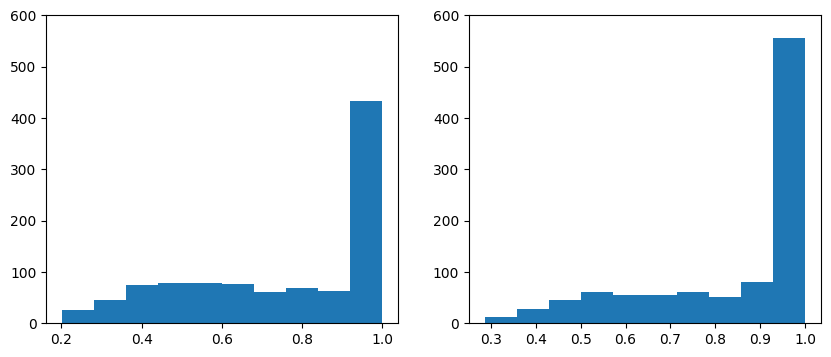

In [ ]:
vl_confs_simple = vl_probs_simple.max(axis=1)
vl_confs_overfit = vl_probs_overfit.max(axis=1)

f, ax = plt.subplots(ncols=2, figsize=(10, 4) )
ax[0].hist(vl_confs_simple), ax[0].set_ylim([0, ylim]);
ax[1].hist(vl_confs_overfit), ax[1].set_ylim([0, ylim]);

Without a noticeable increase in AUC of the overift model, we see higher confidence values, indicating miscalibration. How can we measure this?

# 2. Measuring Model Calibration <a class="anchor" id="measuring"></a>

## 2.A Expected Calibration Error <a class="anchor" id="ece"></a>

Recall its definition as a weighted sum of the gap between confidence and accuracy over binned samples:

$${\large \mathrm{conf-ECE}\,=\,\sum_{i=1}^M \frac{1}{|B_i|} |\mathrm{conf}(B_i) - \mathrm{acc}(B_i)|}$$

The `expected_calibration_error` function in `utils.py` implements the above formula, taking an array of labels, an array of associated probability vectors, and the number `M` of bins (defaults to `M=15`).

In [ ]:
from utils import expected_calibration_error

ece_simple  = expected_calibration_error(vl_labels, vl_probs_simple)
ece_overfit = expected_calibration_error(vl_labels, vl_probs_overfit)

print('* SIMPLE MODEL  - ECE = {:.4f}'.format(ece_simple))
print('* OVERFIT MODEL - ECE = {:.4f}'.format(ece_overfit))

* SIMPLE MODEL  - ECE = 0.0567
* OVERFIT MODEL - ECE = 0.1203


As expected, ECE captures the overconfidence of `overfit_model`. Because ECE does not allow us to understand where miscalibration comes from (over or underconfidence?), we can plot a reliability diagram:

## 2.B Visualization - Reliability Plots <a class="anchor" id="plots"></a>
Because ECE does not allow us to understand where miscalibration comes from, we can plot a reliability diagram.

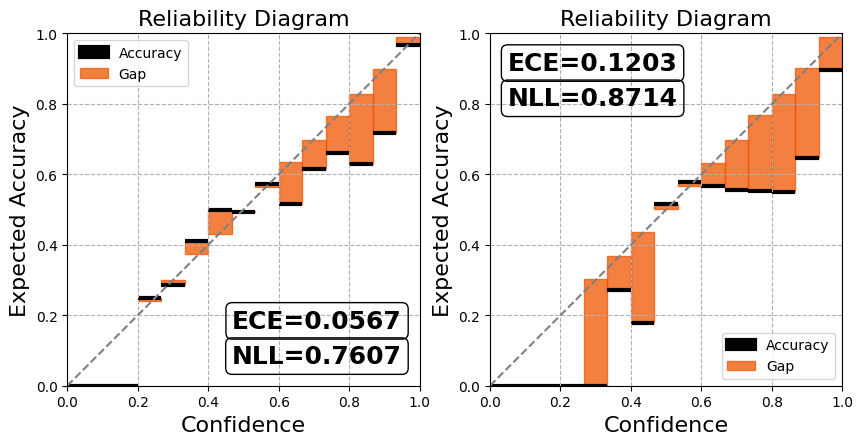

In [ ]:
from utils import plot_reliability_diagram

f, ax = plt.subplots(ncols=2, figsize=(10,10))
plot_reliability_diagram(vl_labels, vl_probs_simple, ax=ax[0])
plot_reliability_diagram(vl_labels, vl_probs_overfit, ax=ax[1])

We can certainly see overconfidence on the overfitted model (right hand side). We also display the NLL, which allows us to study calibration and discrimination jointly.

# 3. Improving Model Calibration <a class="anchor" id="improving"></a>

## 3.A Post-Training Calibration - Temperature Scaling <a class="anchor" id="temp"></a>

This is a simple technique to improve calibration without modifying model predictions: probability distributions change, but the predicted categories (and hence accuracy) remain the same.

Temperature Scaling works by optimizing (in the validation set) a single scalar parameter, which is used to temper the predictions of the network in the pre-softmax logit space:

$${\large \mathbf{\mathbf{\mathcal{p}_{j}}=\,\frac{e^{z_{j\,}}}{\sum_{k=1}^{N}e^{z_{k\,}}}\,\,\longmapsto}\,\,\mathcal{p}_{j}=\,\frac{\mathbf{e^{\left(z_{j}/T\right)}}}{\mathbf{\sum_{k=1}^{N}e^{\left(z_{k}/T\right)}}}}$$

When temperature is >1, scaling reduces logits magnitude, and after applying the softmax overconfidence can be reduced. If temperature is <1, the opposite happens.

Let's see this in action by post-processing the predictions of `overfit_model`.

In [ ]:
# We want to optimize for temperature, so we freeze all other parameters:
for parameter in overfit_model.parameters():
    parameter.requires_grad = False

In [ ]:
# First: collect all the logits and labels on the validation set
logits_overfit_list, labels_list = [], []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        logits_overfit = overfit_model(inputs)

        logits_overfit_list.append(logits_overfit)
        labels_list.append(labels)

logits_overfit = torch.cat(logits_overfit_list)
labels = torch.cat(labels_list).squeeze()
logits_overfit.shape, labels.shape

(torch.Size([1003, 7]), torch.Size([1003]))

The following function takes the stack of logits and labels and finds a temperature value that minimizes NLL, as ECE is non-differentiable:

In [ ]:
def find_optimal_temp(logits, labels):
    temperature = torch.nn.Parameter(1.*torch.ones(1), requires_grad=True)
    optimizer = torch.optim.SGD([temperature], lr=1e-2)
    criterion = torch.nn.CrossEntropyLoss()

    best_nll = 1000
    best_temperature = 1.
    for iteration in range(2000):
        scaled_logits = logits/temperature.to(device)
        nll = criterion(scaled_logits, labels)
        if nll < best_nll:
            best_temp = temperature.item()
            best_nll = nll
        if iteration%200==0: print('Temperature = {:.6f}, NLL = {:.6f}'.format(temperature.item(), nll.item()))
        nll.backward()
        optimizer.step()
        optimizer.zero_grad()

    return best_temp

In [ ]:
print('\nTemperature Scaling for Overfit Model')
best_temp_overfit = find_optimal_temp(logits_overfit, labels)


Temperature Scaling for Overfit Model
Temperature = 1.000000, NLL = 0.873329
Temperature = 1.463088, NLL = 0.750218
Temperature = 1.644076, NLL = 0.733274
Temperature = 1.746185, NLL = 0.727960
Temperature = 1.810787, NLL = 0.725845
Temperature = 1.854044, NLL = 0.724899
Temperature = 1.883979, NLL = 0.724447
Temperature = 1.905130, NLL = 0.724221
Temperature = 1.920284, NLL = 0.724105
Temperature = 1.931244, NLL = 0.724045


Note how the temperature found for the overfit model is >1, as it is overconfident. Observe also how as the temperature values change the NLL decreases. Since accuracy remains the same, we are improving directly calibration here.

Now the question is, have we actually improved ECE by using Temperature Scaling? In order to answer this, we need to **use the test set** because the optimal temperature has been learned on the validation set, so it would be overoptimistic to measure performance there.

The function `run_one_epoch` we used above can take an optional temperature scaling parameter (defaults to 1), so we use it here to compute ECE on the test set before and after scaling.

In [ ]:
_, test_probs_overfit, test_labels = run_one_epoch(test_loader, overfit_model, temperature=1.)
pre_temperature_ece_overfit = expected_calibration_error(test_labels, test_probs_overfit)

_, test_probs_overfit_ts, test_labels = run_one_epoch(test_loader, overfit_model, temperature=best_temp_overfit)
post_temperature_ece_overfit = expected_calibration_error(test_labels, test_probs_overfit_ts)

In [ ]:
print('Overfit Model: Temperature = {:.4f}, ECE = {:.4f} --> {:.4f}'.format(best_temp_overfit,
                                                                            pre_temperature_ece_overfit,
                                                                            post_temperature_ece_overfit))

Overfit Model: Temperature = 1.9392, ECE = 0.1135 --> 0.0306


Let us also plot reliability diagrams:

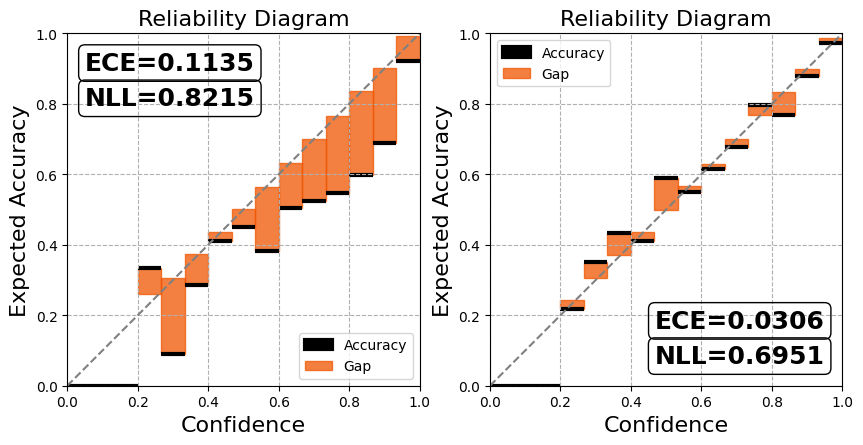

In [ ]:
f, ax = plt.subplots(ncols=2, figsize=(10,10))
plot_reliability_diagram(test_labels, test_probs_overfit, ax=ax[0])
plot_reliability_diagram(test_labels, test_probs_overfit_ts, ax=ax[1])

## 3.B Training Time Calibration - Label Smoothing  <a class="anchor" id="ls"></a>
As mentioned in the slides, regularization mechanisms like **Label Smoothing** can be effective against overconfidence, at the risk of overfitting.

We have trained a new model for the same amount of epochs as in `overfit_model`, but with a (rather large) label smoothing value of `ls=0.5`. Let us load it up:

In [ ]:
LS_model  = resnet18(num_classes=N_CLASSES).to(device)
if dataset == 'DERMA':
    LS_model.load_state_dict(torch.load('weights/derma_LS_model_Ep20.pth', map_location=device));
else:
    LS_model.load_state_dict(torch.load('weights/retina_LS_model_Ep10.pth', map_location=device));

Now we repeat the steps for evaluating performance that we made above for the simple and overfit models:

In [ ]:
with torch.inference_mode(): # inference for ls_model
    tr_preds_LS, tr_probs_LS, tr_labels = run_one_epoch(train_loader, LS_model)
    vl_preds_LS, vl_probs_LS, vl_labels = run_one_epoch(val_loader, LS_model)
# performance of ls_model
tr_auc_LS = roc_auc_score(tr_labels, tr_probs_LS, multi_class='ovr')
vl_auc_LS = roc_auc_score(vl_labels, vl_probs_LS, multi_class='ovr')

For reference, let us recall performance of all models on the validation set:

In [ ]:
print('* SIMPLE MODEL           - TR/VL AUC={:.2f}/{:.2f}'.format(100*tr_auc_simple, 100*vl_auc_simple))
print('* OVERFIT MODEL          - TR/VL AUC={:.2f}/{:.2f}'.format(100*tr_auc_overfit, 100*vl_auc_overfit))
print('* LABEL SMOOTHING MODEL  - TR/VL AUC={:.2f}/{:.2f}'.format(100*tr_auc_LS, 100*vl_auc_LS))

* SIMPLE MODEL           - TR/VL AUC=92.90/90.52
* OVERFIT MODEL          - TR/VL AUC=98.40/91.73
* LABEL SMOOTHING MODEL  - TR/VL AUC=92.74/90.74


We see that even if we trained for as long as with the overfit model, we avoided overfitting with Label Smoothing. Let us visually inspect confidence values for each of our three models:

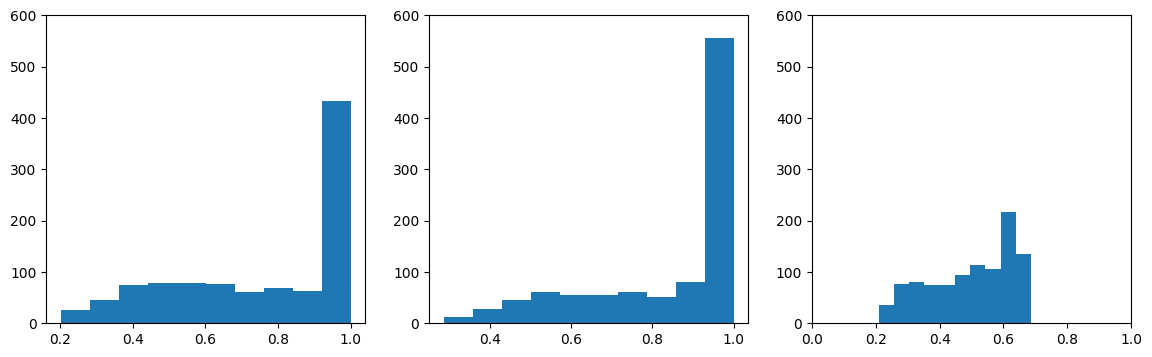

In [ ]:
vl_confs_LS = vl_probs_LS.max(axis=1)

f, ax = plt.subplots(ncols=3, figsize=(14, 4))
ax[0].hist(vl_confs_simple), ax[0].set_ylim([0, ylim]);
ax[1].hist(vl_confs_overfit), ax[1].set_ylim([0, ylim]);
ax[2].hist(vl_confs_LS), ax[2].set_ylim([0, ylim]), ax[2].set_xlim([0, 1]);

Label smoothing succeeds at combatting overconfidence, but we might be having a problem of underconfidence now!

Let us examine calibration errors and reliability plots:

In [ ]:
ece_simple  = expected_calibration_error(vl_labels, vl_probs_simple)
ece_overfit = expected_calibration_error(vl_labels, vl_probs_overfit)
ece_LS      = expected_calibration_error(vl_labels, vl_probs_LS)
print('ECE-simple = {:.4f}, ECE-overfit = {:.4f}, ECE-LS = {:.4f}'.format(ece_simple, ece_overfit, ece_LS))

ECE-simple = 0.0567, ECE-overfit = 0.1203, ECE-LS = 0.2724


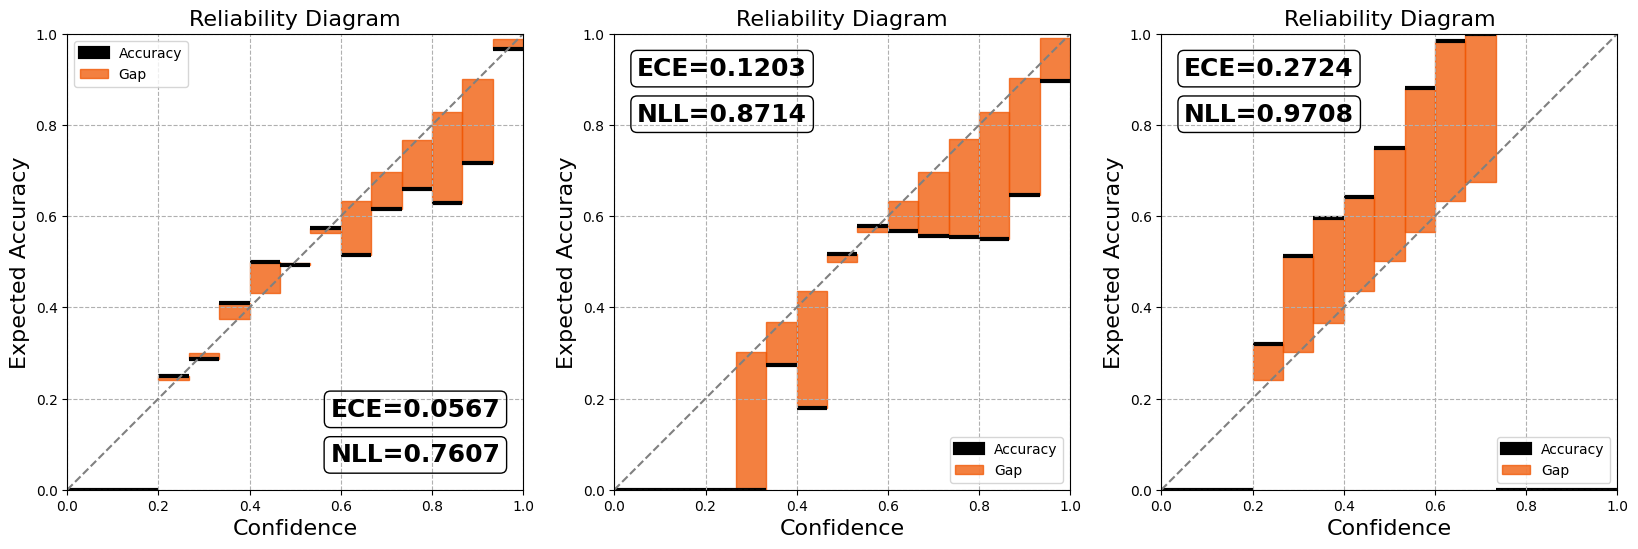

In [ ]:
f, ax = plt.subplots(ncols=3, figsize=(20,20))
plot_reliability_diagram(vl_labels, vl_probs_simple, ax=ax[0])
plot_reliability_diagram(vl_labels, vl_probs_overfit, ax=ax[1])
plot_reliability_diagram(vl_labels, vl_probs_LS, ax=ax[2])

Miscalibration due to underconfidence appears obvious from the rightmost plot. We can apply temperature scaling to the label smoothing model to fix this.